In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from IPython.display import HTML
from collections import Counter
from nltk.corpus import stopwords
import nltk

In [2]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

## Conversion Rates.

In [3]:
df['conversion'] = df['y'].apply(lambda x: 1 if x == 'yes' else 0) 

In [4]:
#Total number of conversions
n_conv = df.conversion.sum()
#Total number of clientes in the data.
n_clients = df.shape[0]

In [5]:
print('total conversions: %i out of %i' % (n_conv, n_clients))

total conversions: 4640 out of 41188


In [6]:
print('conversion rate: %0.2f%%' % (n_conv/n_clients * 100.0))

conversion rate: 11.27%


## Conversion Rates by Age

In [7]:
conv_by_age = df.groupby('age')['conversion'].sum() / df.groupby('age')['conversion'].count()*100.0

In [8]:
conv_by_age.head()

age
17    40.000000
18    42.857143
19    47.619048
20    35.384615
21    28.431373
Name: conversion, dtype: float64

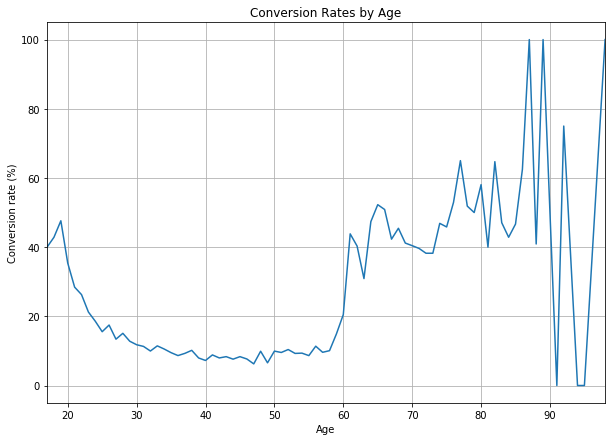

In [9]:
ax = conv_by_age.plot(grid=True, figsize=(10,7), title='Conversion Rates by Age')
ax.set_xlabel('Age')
ax.set_ylabel('Conversion rate (%)')
plt.show()

In [10]:
#Reducing noise of the age-groups.
df['age_group'] = df['age'].apply(lambda x: '18 to 30' if x < 30 else '30 to 40'\
                                                      if x < 40 else '40 to 50'\
                                                      if x < 50 else '50 to 60'\
                                                      if x < 60 else '60 to 70'\
                                                      if x < 70 else '70+')

In [11]:
convs_by_age_group = df.groupby('age_group')['conversion'].sum()/df.groupby('age_group')['conversion'].count()*100.0

In [12]:
convs_by_age_group.head()

age_group
18 to 30    16.263891
30 to 40    10.125162
40 to 50     7.923238
50 to 60    10.157389
60 to 70    34.668508
Name: conversion, dtype: float64

In [13]:
convs_by_age_group

age_group
18 to 30    16.263891
30 to 40    10.125162
40 to 50     7.923238
50 to 60    10.157389
60 to 70    34.668508
70+         47.121535
Name: conversion, dtype: float64

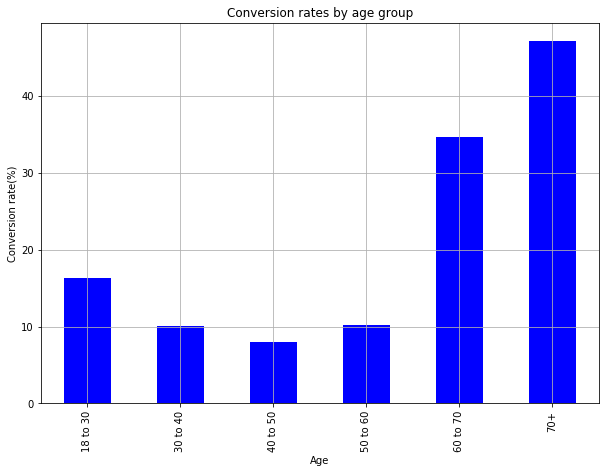

In [14]:
ax = convs_by_age_group.plot(kind='bar', color='blue', grid=True, figsize=(10,7), title='Conversion rates by age group')
ax.set_xlabel('Age')
ax.set_ylabel('Conversion rate(%)')
plt.show()

## Differences between converted clients and non-converted clients

In [25]:
conversions_by_marital_status = pd.pivot_table(df, values='y', index='marital', columns='conversion', aggfunc=len)

In [26]:
conversions_by_marital_status.columns = ['non_conversions', 'conversions']

In [27]:
conversions_by_marital_status

,non_conversions,conversions
marital,,
divorced,4136,476
married,22396,2532
single,9948,1620
unknown,68,12


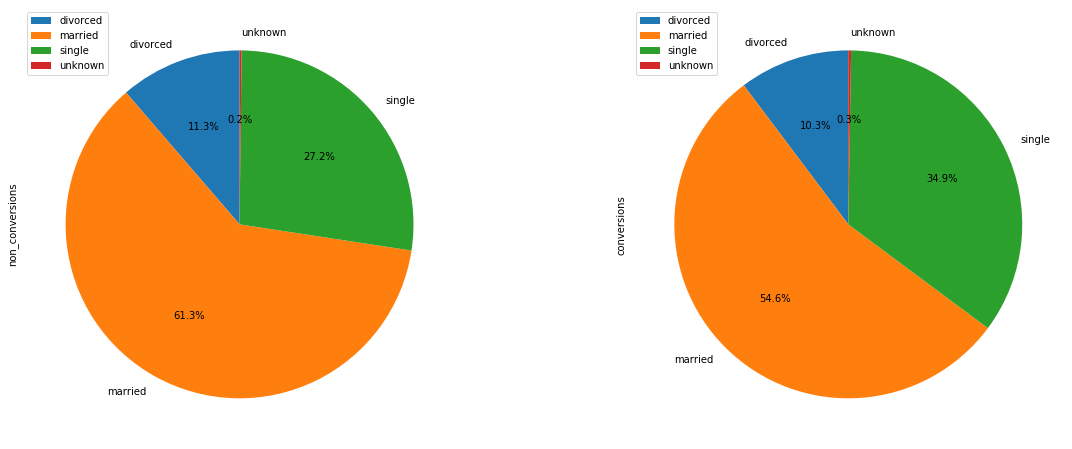

In [28]:
conversions_by_marital_status.plot(
    kind='pie',
    figsize=(20,8),
    startangle=90,
    subplots=True, #needed if there are more than 1 column and want to create plot for each of them.
    autopct=lambda x: '%0.1f%%' % x #format the label for each group
)

plt.show()

### Conversions by education

In [29]:
convs_by_education = pd.pivot_table(df, values='y', index='education', columns='conversion', aggfunc=len)

In [30]:
convs_by_education.columns = ['non_conversion', 'conversion']

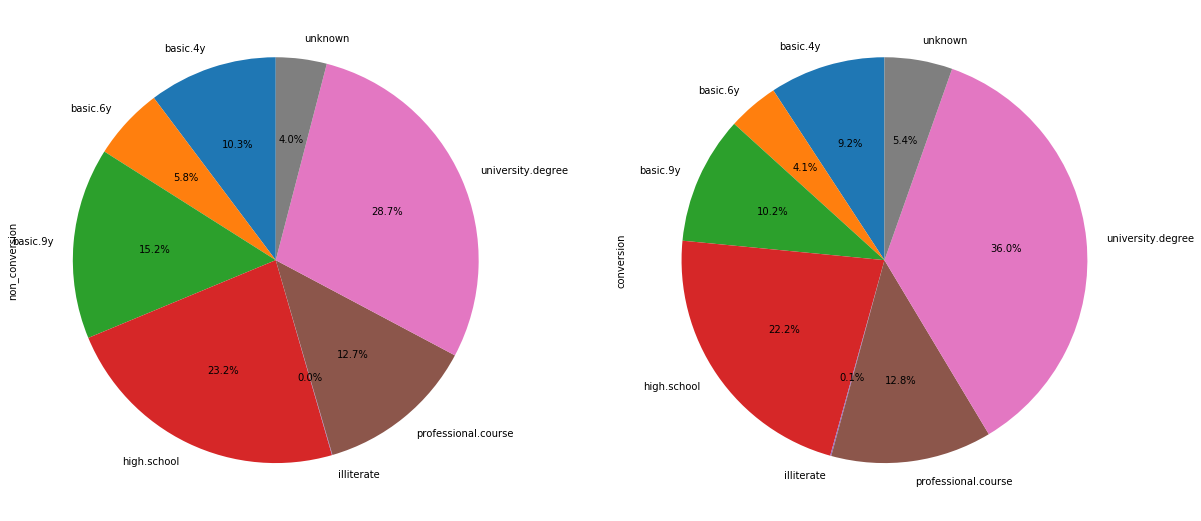

In [36]:
convs_by_education.plot(
    kind='pie',
    figsize=(20,10),
    startangle=90,
    subplots=True,
    autopct=lambda x: '%0.1f%%' % x,
    legend=False
)
plt.show()

### Last contact duration

In [53]:
df.groupby('conversion')['duration'].describe()

,count,mean,std,min,25%,50%,75%,max
conversion,,,,,,,,
0,36548.0,220.844807,207.096293,0.0,95.0,163.5,279.00,4918.0
1,4640.0,553.191164,401.171871,37.0,253.0,449.0,741.25,4199.0


In [59]:
duration_df = pd.concat([df.loc[df['conversion'] == 1, 'duration'].reset_index(drop=True),
                         df.loc[df['conversion']== 0, 'duration'].reset_index(drop=True)], axis=1)

duration_df.columns=['conversion', 'non_conversions']

duration_df = duration_df/3600

In [62]:
duration_df.head()

,conversion,non_conversions
0,0.437500,0.072500
1,0.289444,0.041389
2,0.407500,0.062778
3,0.160833,0.041944
4,0.128056,0.085278


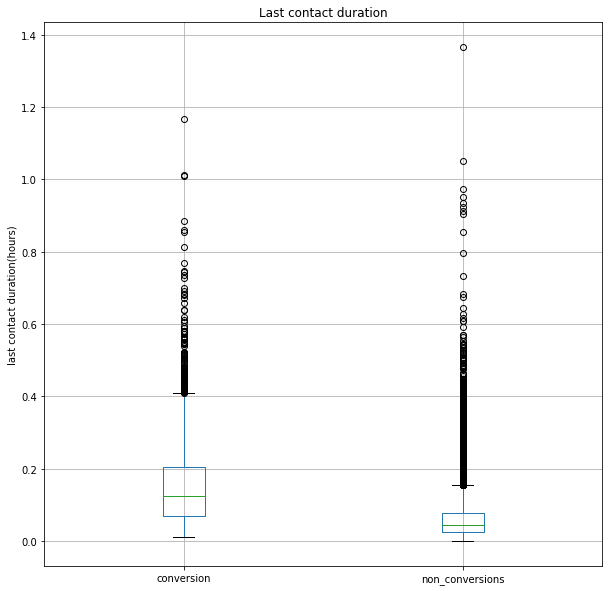

In [64]:
ax = duration_df.plot(
    kind='box',
    grid=True,
    figsize=(10,10)
)

ax.set_ylabel('last contact duration(hours)')
ax.set_title('Last contact duration')

plt.show()

## Conversions by age groups and marital status

In [69]:
#Grouping the data by two columns age_group and marital status then summing the number of conversions 
age_marital_df = df.groupby(['age_group', 'marital'])['conversion'].sum().unstack('marital').fillna(0)

In [71]:
#Divide by the the total of clients in each group
age_marital_df = age_marital_df.divide(df.groupby('age_group')['conversion'].count(), axis=0)

In [81]:
age_marital_df = age_marital_df * 100

In [82]:
age_marital_df

marital,divorced,married,single,unknown
age_group,,,,
18 to 30,0.211678,2.787088,13.247486,0.017640
30 to 40,0.755697,5.295785,4.038257,0.035423
40 to 50,1.197036,5.462664,1.235037,0.028501
50 to 60,1.734188,7.767415,0.641212,0.014573
60 to 70,3.729282,30.110497,0.690608,0.138122
70+,13.646055,32.196162,1.279318,0.000000


In [83]:
ages = age_marital_df.index.to_list()

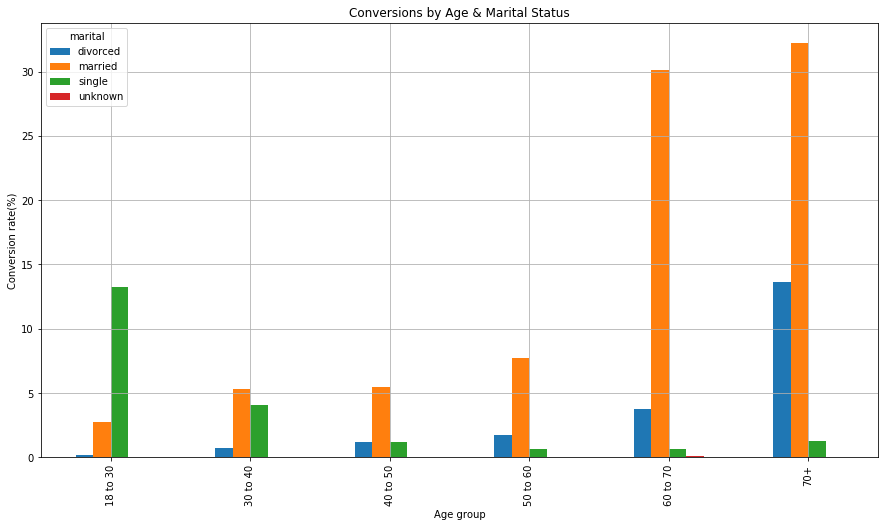

In [85]:
ax = age_marital_df.loc[ages].plot(
    kind='bar',
    grid=True,
    figsize=(15,8)
)
ax.set_title('Conversions by Age & Marital Status')
ax.set_xlabel('Age group')
ax.set_ylabel('Conversion rate(%)')

plt.show()

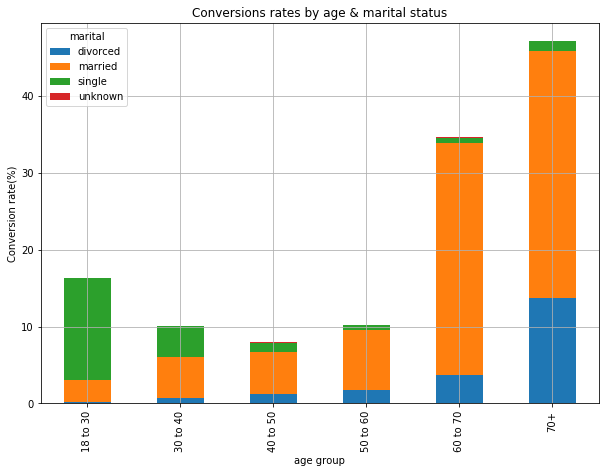

In [86]:
ax = age_marital_df.loc[ages].plot(
    kind='bar',
    stacked=True,
    grid=True,
    figsize=(10,7)
)

ax.set_title('Conversions rates by age & marital status')
ax.set_xlabel('age group')
ax.set_ylabel('Conversion rate(%)')

plt.show()